In [1]:
library(tidyverse)
library(jsonlite)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten




# Data Munging (for GPS and Weather)

In [2]:
gps_raw <- list()
for (file in list.files('gps')) {
    gps_raw[[file]] <- fromJSON(paste('gps/', file, sep=''), simplifyVector=TRUE)
}

In [3]:
# now pull out the coordinates
coords <- map(gps_raw, function (data) {t(simplify2array(data$features$geometry$coordinates))})

In [4]:
days_dfs <- map(names(gps_raw), function(name) {
    data.frame(time =strptime(gps_raw[[name]]$features$properties$time,format = "%Y-%m-%dT%H:%M:%S"),
               longitude = coords[[name]][,1],
               latitude = coords[[name]][,2])
})
names(days_dfs) <- names(gps_raw)

In [5]:
head(days_dfs[[1]], 3)
tail(days_dfs[[11]], 2)

,time,longitude,latitude
,<dttm>,<dbl>,<dbl>
1,2020-08-18 17:50:42,-114.0003,46.88678
2,2020-08-18 17:50:40,-114.0005,46.88632
3,2020-08-18 17:51:49,-113.9999,46.88604


,time,longitude,latitude
,<dttm>,<dbl>,<dbl>
866,2020-08-31 22:48:46,-114.0002,46.88728
867,2020-08-31 22:48:55,-114.0001,46.88740


### Process Weather Data

In [6]:
weather_raw <- fromJSON('historical_weather.json', simplifyVector=TRUE)
weather_obs <- weather_raw$observations
head(weather_obs)
colnames(weather_obs)
temperature_all <- weather_obs[, c('valid_time_gmt', 'temp')]

,key,class,expire_time_gmt,obs_id,obs_name,valid_time_gmt,day_ind,temp,wx_icon,icon_extd,⋯,clds,water_temp,primary_wave_period,primary_wave_height,primary_swell_period,primary_swell_height,primary_swell_direction,secondary_swell_period,secondary_swell_height,secondary_swell_direction
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,⋯,<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,KMSO,observation,1597567980,KMSO,Missoula,1597560780,N,60,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,KMSO,observation,1597571580,KMSO,Missoula,1597564380,N,61,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,KMSO,observation,1597575180,KMSO,Missoula,1597567980,N,57,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,KMSO,observation,1597578780,KMSO,Missoula,1597571580,N,54,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,KMSO,observation,1597582380,KMSO,Missoula,1597575180,N,50,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,KMSO,observation,1597585980,KMSO,Missoula,1597578780,N,48,33,3300,⋯,CLR,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "key"                       "class"                    
 [3] "expire_time_gmt"           "obs_id"                   
 [5] "obs_name"                  "valid_time_gmt"           
 [7] "day_ind"                   "temp"                     
 [9] "wx_icon"                   "icon_extd"                
[11] "wx_phrase"                 "pressure_tend"            
[13] "pressure_desc"             "dewPt"                    
[15] "heat_index"                "rh"                       
[17] "pressure"                  "vis"                      
[19] "wc"                        "wdir"                     
[21] "wdir_cardinal"             "gust"                     
[23] "wspd"                      "max_temp"                 
[25] "min_temp"                  "precip_total"             
[27] "precip_hrly"               "snow_hrly"                
[29] "uv_desc"                   "feels_like"               
[31] "uv_index"                  "qualifier"                
[33] "qualifier_svrty"           "blunt_phrase"             
[35] "terse_phrase"              "clds"                     
[37] "water_temp"                "primary_wave_period"      
[39] "primary_wave_height"       "primary_swell_period"     
[41] "primary_swell_height"      "primary_swell_direction"  
[43] "secondary_swell_period"    "secondary_swell_height"   
[45] "secondary_swell_direction"

In [7]:
# verify observations are once every hour
temperature_all[2:6, 1] - temperature_all[1:5, 1]

[1] 3600 3600 3600 3600 3600

# Put Data Together & Explore

In [8]:
# now heap coordinates together with flag for their day
num_total <- sum(unlist(lapply(days_dfs, function(df) {return(dim(df)[1])})))
num_total
reduced_df <- data.frame(
    index=unlist(lapply(days_dfs, function(df) {return(1:length(df$time))})),
    time=unlist(lapply(days_dfs, function(df) {return(df$time)})),
    elapsed=unlist(lapply(days_dfs, function(df) {return(df$time - df$time[1])})),
    longitude=unlist(lapply(days_dfs, function(df) {return(df$longitude)})),
    latitude=unlist(lapply(days_dfs, function(df) {return(df$latitude)})),
    day=factor(unlist(lapply(1:length(days_dfs),
                                    function(idx) {return(rep(idx, length(days_dfs[[idx]]$longitude)))}
                                   )))
)

[1] 5857

In [9]:
# now get UTM coordinates
library(sp)
spat_df <-SpatialPointsDataFrame(coords=reduced_df[,c("longitude", "latitude")],
                                 data=reduced_df["time"],
                                 proj4string=CRS("+proj=longlat +datum=WGS84 +units=m"))# This step converts the longitude/latitude -> UTM
utm_df <-spTransform(spat_df, CRSobj = "+proj=utm +zone=12 +datum=WGS84 +units=m")
utm_coords <- coordinates(utm_df)
reduced_df$lat_m <- utm_coords[, "latitude"]
reduced_df$long_m <- utm_coords[, "longitude"]

In [10]:
# now pair data to temperature via linear interpolation
indices <- unlist(lapply(reduced_df$time, function(time) {which(temperature_all[, 1] > time)[1]}))
first_temp <- temperature_all[indices-1, 2]
second_temp <- temperature_all[indices, 2]
# now interpolate
diff <- temperature_all[indices, 1] - temperature_all[indices-1, 1]
weight <- (reduced_df$time - temperature_all[indices-1, 1])/diff
final_temps <- first_temp*(1-weight) + second_temp*weight

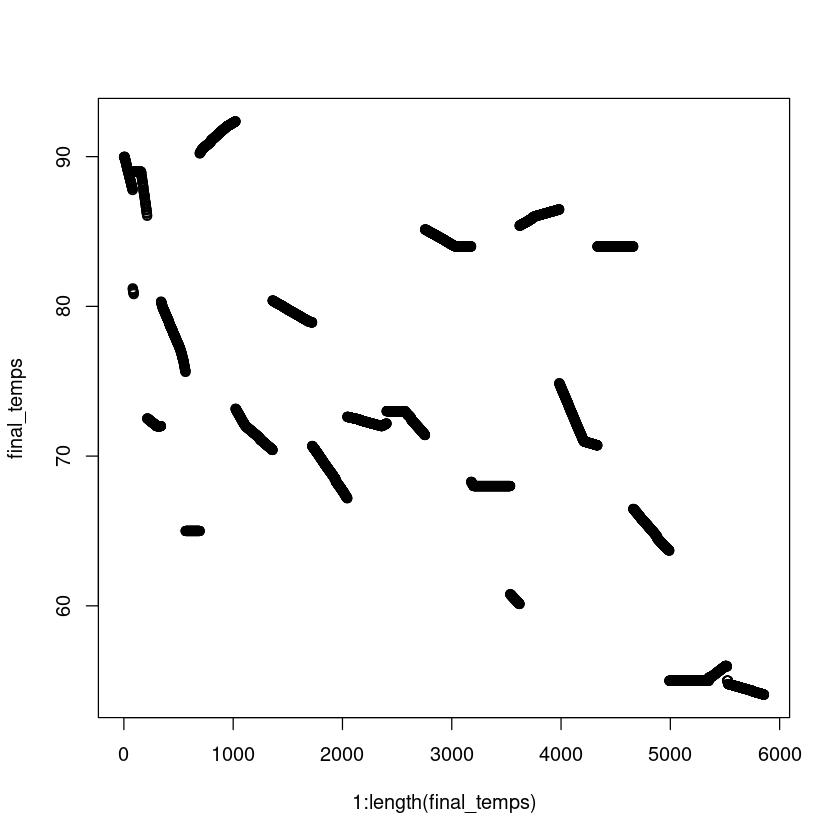

In [11]:
plot(1:length(final_temps), final_temps)

In [12]:
# now add temperature to dataframe
reduced_df$temperature <- final_temps

In [13]:
head(reduced_df)

,index,time,elapsed,longitude,latitude,day,lat_m,long_m,temperature
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
20200818114606.geojson1,1,1597787442,0,-114.0003,46.88678,1,5196954,271422.2,89.96167
20200818114606.geojson2,2,1597787440,-2,-114.0005,46.88632,1,5196903,271407.1,89.96111
20200818114606.geojson3,3,1597787509,67,-113.9999,46.88604,1,5196870,271456.3,89.98028
20200818114606.geojson4,4,1597787544,102,-113.9992,46.88620,1,5196886,271504.3,89.99000
20200818114606.geojson5,5,1597787592,150,-113.9978,46.88587,1,5196845,271614.3,89.99000
20200818114606.geojson6,6,1597787591,149,-113.9972,46.88593,1,5196850,271656.7,89.99083


Warning message:
“Removed 114 rows containing missing values (geom_point).”


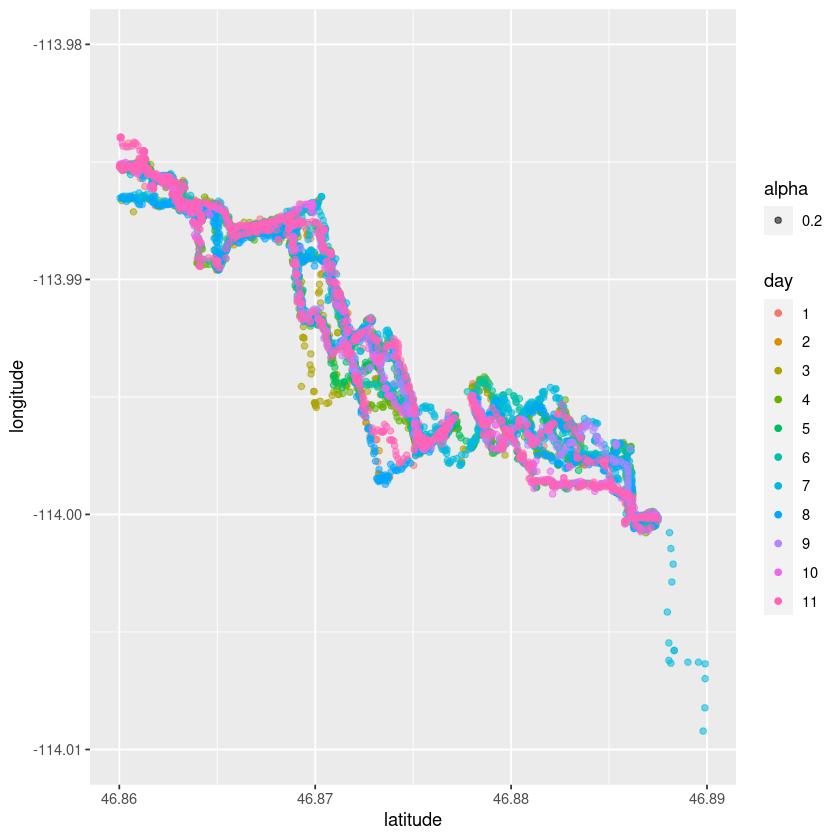

In [14]:
ggplot(reduced_df, aes(x=latitude, y=longitude, color=day, alpha=0.2)) +
    geom_point() +
    ylim(-114.01, -113.98) +
    xlim(46.86, 46.89)

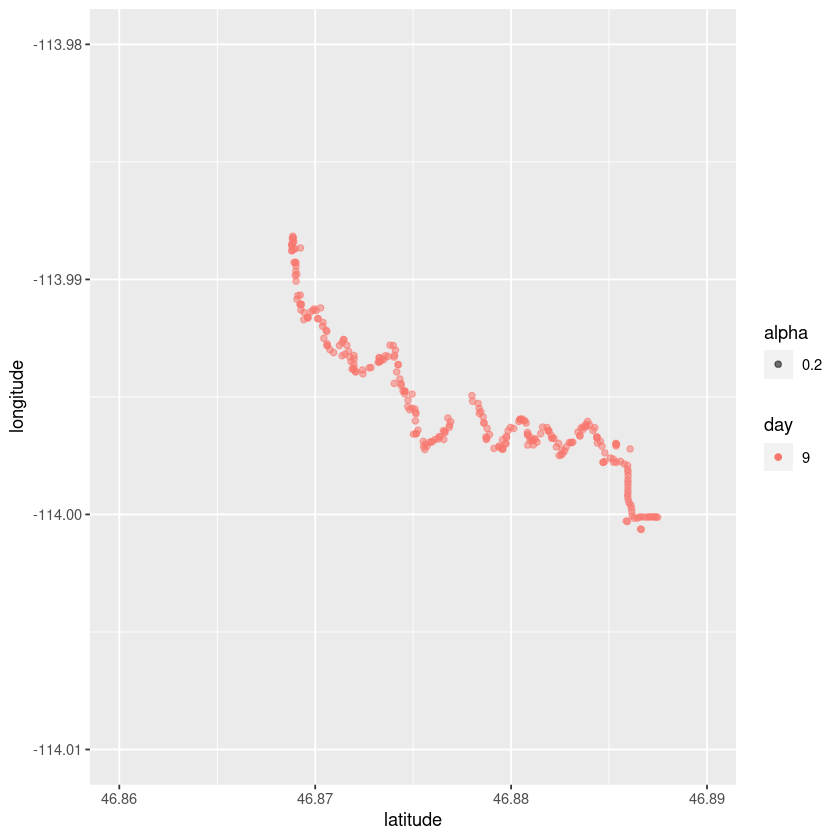

In [104]:
ggplot(reduced_df[reduced_df$day == 9, ], aes(x=latitude, y=longitude, color=day, alpha=0.2)) +
    geom_point() +
    ylim(-114.01, -113.98) +
    xlim(46.86, 46.89)

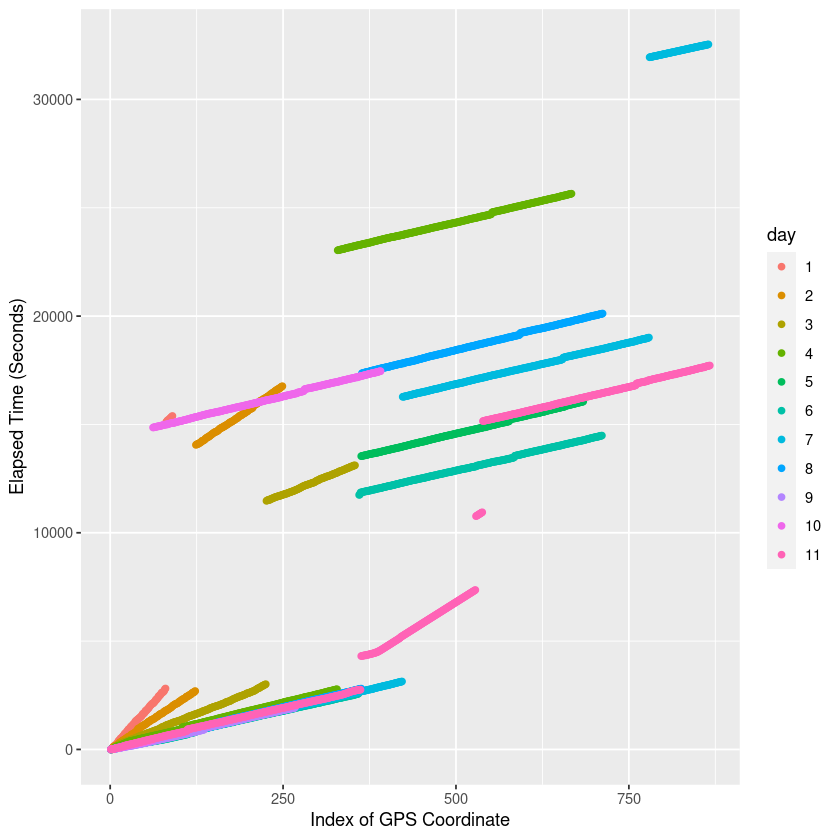

In [15]:
# now analyze in the time dimension
ggplot(reduced_df, aes(x=index, y=elapsed, color=day)) +
    geom_point() +
    ylab("Elapsed Time (Seconds)") +
    xlab("Index of GPS Coordinate")

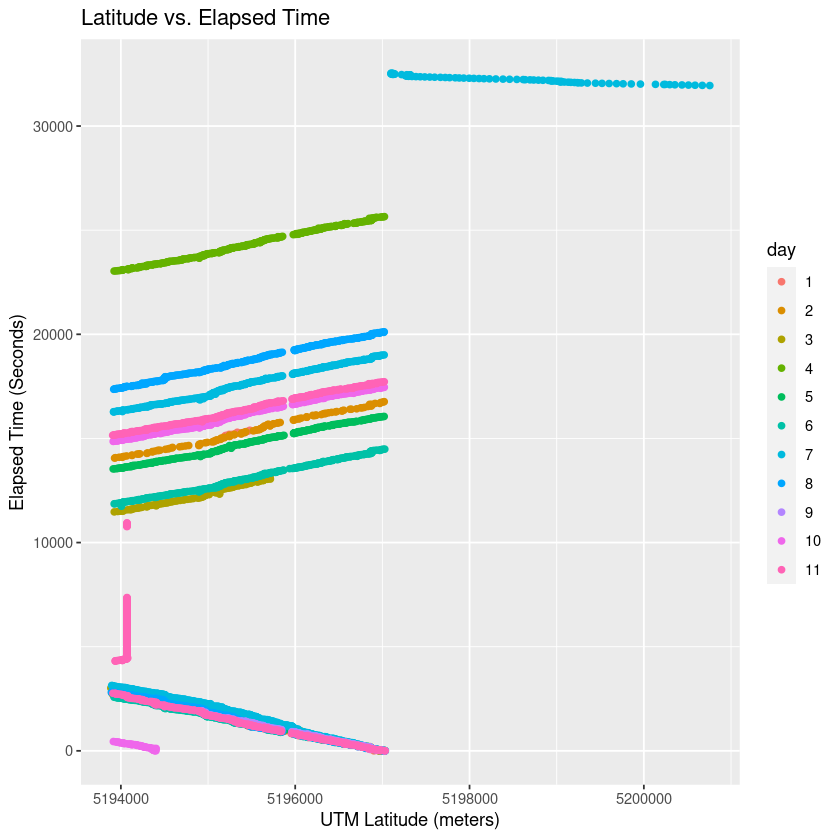

In [16]:
# now analyze in the time dimension
ggplot(reduced_df, aes(x=lat_m, y=elapsed, color=day)) +
    geom_point() +
    labs(title="Latitude vs. Elapsed Time",
         y="Elapsed Time (Seconds)",
         x="UTM Latitude (meters)")

In [17]:
length(days_dfs)

[1] 11

In [18]:
# now map "bombable" times
diff_time <- reduced_df$time[2:length(reduced_df$time)] - reduced_df$time[1:(length(reduced_df$time)-1)]
stationary <- c(TRUE, diff_time > 2*60)
reduced_df$stationary <- stationary
# TODO: MAKE IT CHECK IF YOU ARE LESS THAN 5 MINUTES FROM LAST STATIONARY
time_to_stationary <- unlist(map(reduced_df$time, function(time) {
    stat_diff <- time - reduced_df$time[reduced_df$stationary]
    ifelse(length(stat_diff[stat_diff >= 0]) != 0, min(stat_diff[stat_diff >= 0]), 0)
}))
reduced_df$bombable <- time_to_stationary > 5*60

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 57 rows containing missing values (geom_point).”


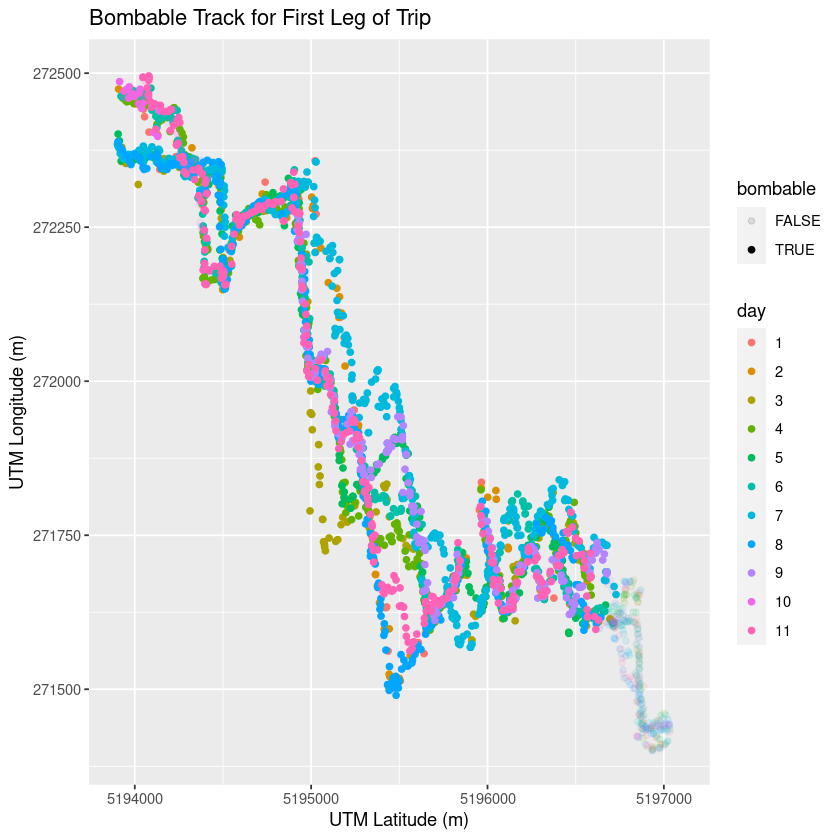

In [163]:
# plot hiding the non-bombable points
bombable <- ifelse(reduced_df$bombable, 0.9, 0.1)
ggplot(reduced_df[reduced_df$elapsed < 5000, ], aes(x=lat_m, y=long_m, color=day, alpha=bombable)) +
    geom_point() +
    ylim(271400, 272500) +
    xlim(5193900, 5197100) +
    labs(title="Bombable Track for First Leg of Trip",
         y="UTM Longitude (m)", x="UTM Latitude (m)")

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 2171 rows containing missing values (geom_point).”


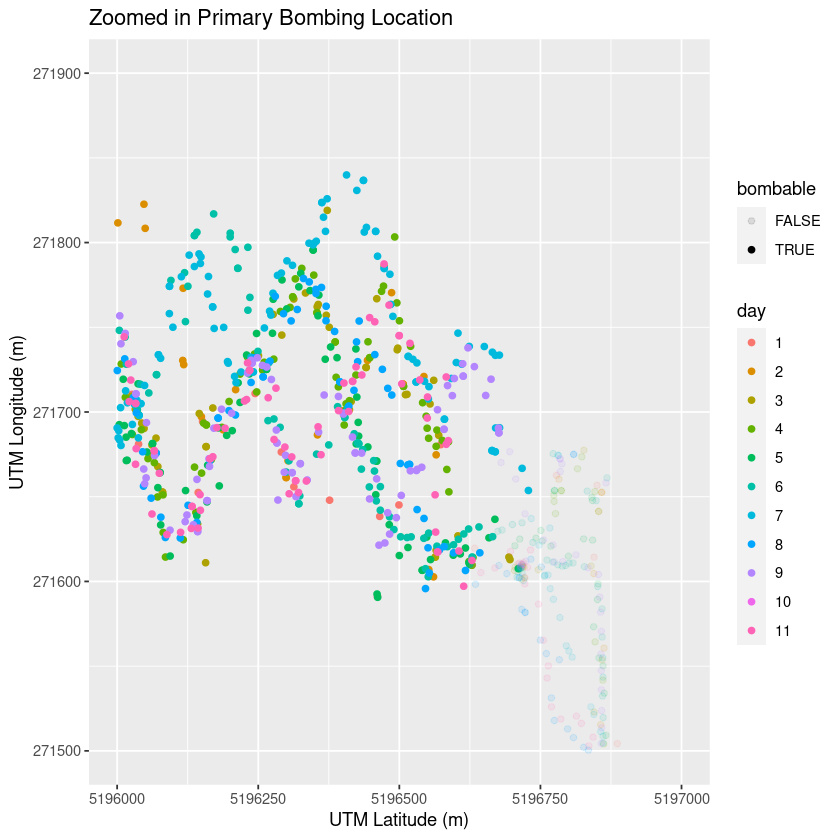

In [167]:
# plot hiding the non-bombable points
bombable <- ifelse(reduced_df$bombable, 0.9, 0.1)
ggplot(reduced_df[reduced_df$elapsed < 5000, ], aes(x=lat_m, y=long_m, color=day, alpha=bombable)) +
    geom_point() +
    ylim(271500, 271900) +
    xlim(5196000, 5197000) +
    labs(title="Zoomed in Primary Bombing Location",
         y="UTM Longitude (m)", x="UTM Latitude (m)")

Warning message:
“Using alpha for a discrete variable is not advised.”


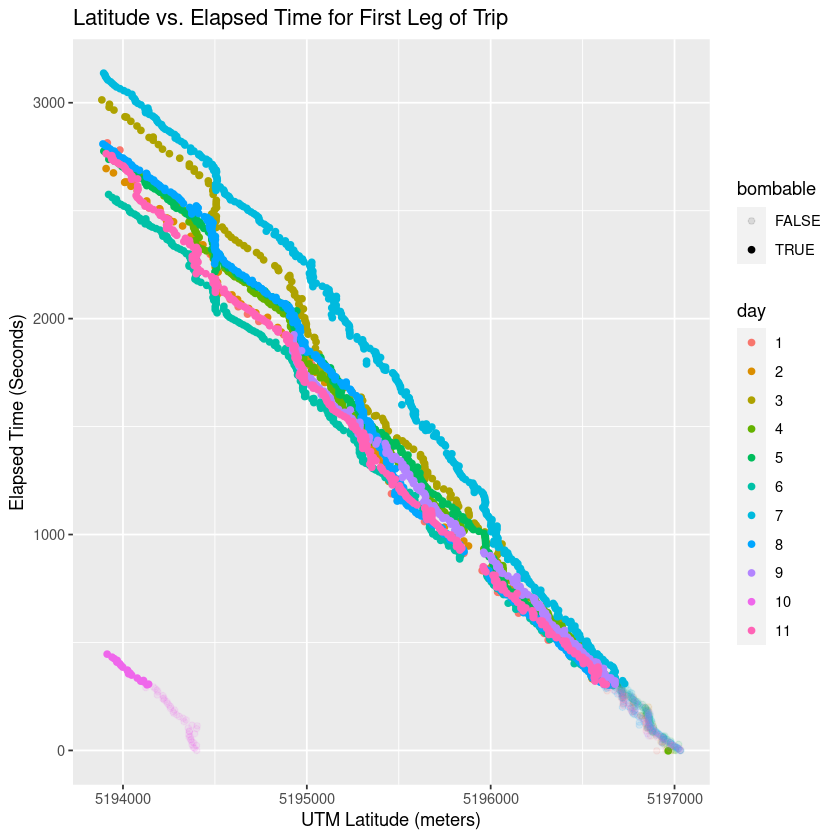

In [160]:
# now analyze in the time dimension
ggplot(reduced_df[reduced_df$elapsed < 4000, ], aes(x=lat_m, y=elapsed, color=day, alpha=bombable)) +
    geom_point() +
    labs(title="Latitude vs. Elapsed Time for First Leg of Trip",
         y="Elapsed Time (Seconds)",
         x="UTM Latitude (meters)")

Warning message:
“Using alpha for a discrete variable is not advised.”
Warning message:
“Removed 2019 rows containing missing values (geom_point).”


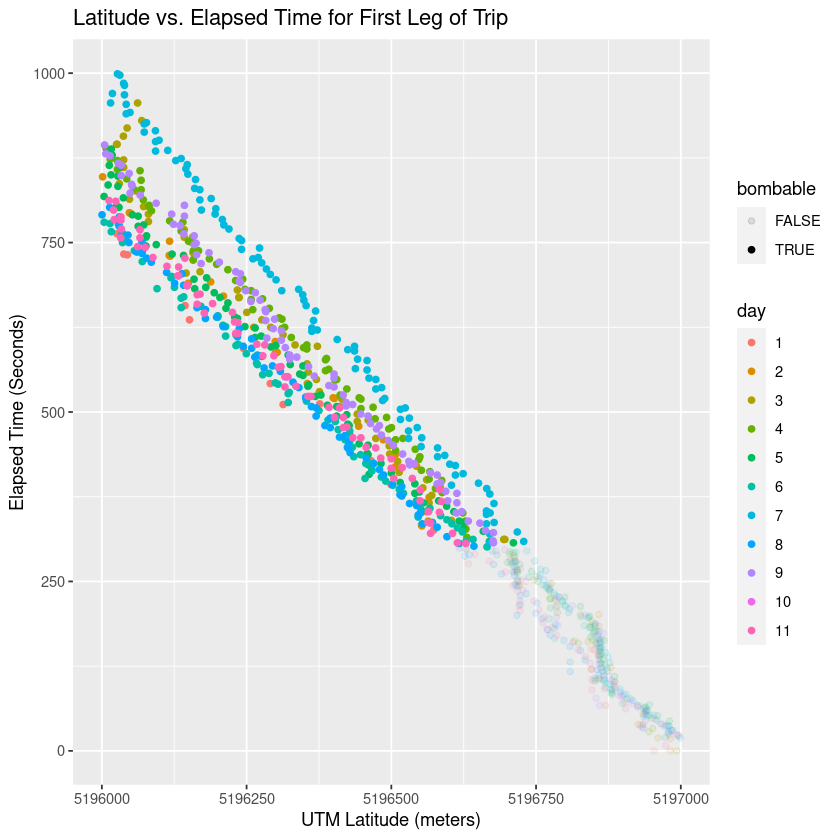

In [170]:
# now analyze in the time dimension
ggplot(reduced_df[reduced_df$elapsed < 4000, ], aes(x=lat_m, y=elapsed, color=day, alpha=bombable)) +
    geom_point() +
    labs(title="Latitude vs. Elapsed Time for First Leg of Trip",
         y="Elapsed Time (Seconds)",
         x="UTM Latitude (meters)") +
    ylim(0, 1000) +
    xlim(5196000, 5197000)

## Predict Elapsed Time Differential Based on Latitude

In [79]:
real_dist <- function(long1, lat1, long2, lat2) {
    return(sqrt((long1 - long2)^2 + (lat1 - lat2)^2))
}

In [107]:
lat_vals <- seq(5194000, 5197000, by=10)

allowlist_days <- c(1:8,11)

elapsed_per_lat <- map(lat_vals, function(lat) {
    unlist(map(allowlist_days, function(day) {
        days_data <- reduced_df[reduced_df$elapsed < 4000, ]
        days_data <- days_data[days_data$day == day, ]
        dists <- abs(days_data$lat_m - lat)
        return(days_data$elapsed[which.min(dists)])
    }))
})

temperature_per_lat <- map(lat_vals, function(lat) {
    unlist(map(allowlist_days, function(day) {
        days_data <- reduced_df[reduced_df$elapsed < 4000, ]
        days_data <- days_data[days_data$day == day, ]
        dists <- abs(days_data$lat_m - lat)
        return(days_data$temperature[which.min(dists)])
    }))
})
names(elapsed_per_lat) <- lat_vals
names(temperature_per_lat) <- lat_vals

5194000  5194010  5194020  5194030  5194040  5194050 
2757.444 2737.556 2732.111 2726.444 2725.000 2721.000

,temperature,elapsed,latitude,day,mean_elapsed,elapsed_diff
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
51940001,87.79750,2781,5194000,1,2757.444,23.55556
51940002,86.20496,2631,5194000,2,2757.444,-126.44444
51940003,75.79111,2935,5194000,3,2757.444,177.55556
51940004,92.33389,2738,5194000,4,2757.444,-19.44444
51940005,78.94500,2704,5194000,5,2757.444,-53.44444
51940006,72.15111,2521,5194000,6,2757.444,-236.44444



Call:
lm(formula = elapsed_diff ~ latitude + mean_elapsed * log(temperature), 
    data = temperature_train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-229.22  -70.34  -12.56   23.97  392.08 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -2.372e+04  3.276e+05  -0.072    0.942    
latitude                       4.547e-03  6.304e-02   0.072    0.942    
mean_elapsed                  -5.294e-01  1.061e-01  -4.987 6.52e-07 ***
log(temperature)               1.895e+01  3.028e+01   0.626    0.531    
mean_elapsed:log(temperature)  1.222e-01  1.899e-02   6.438 1.43e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 120.3 on 2704 degrees of freedom
Multiple R-squared:  0.06383,	Adjusted R-squared:  0.06245 
F-statistic: 46.09 on 4 and 2704 DF,  p-value: < 2.2e-16


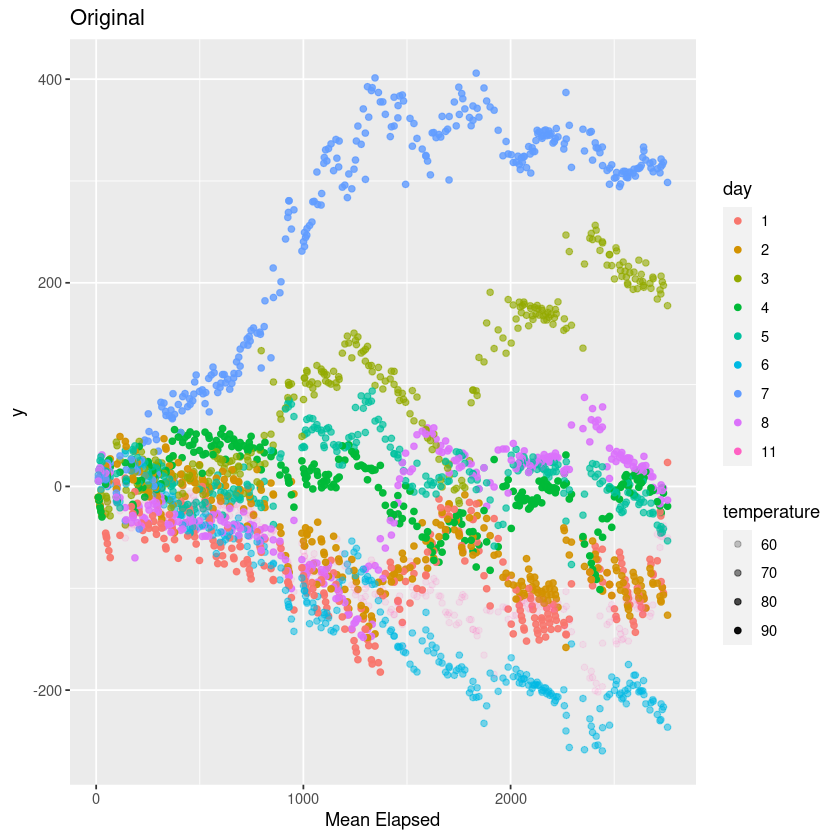

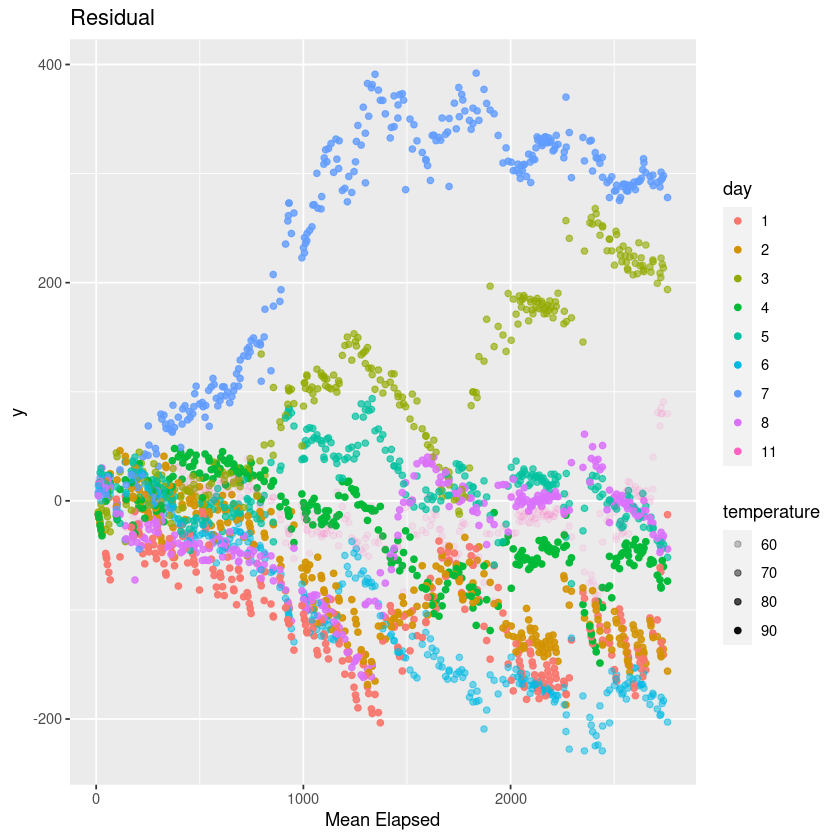

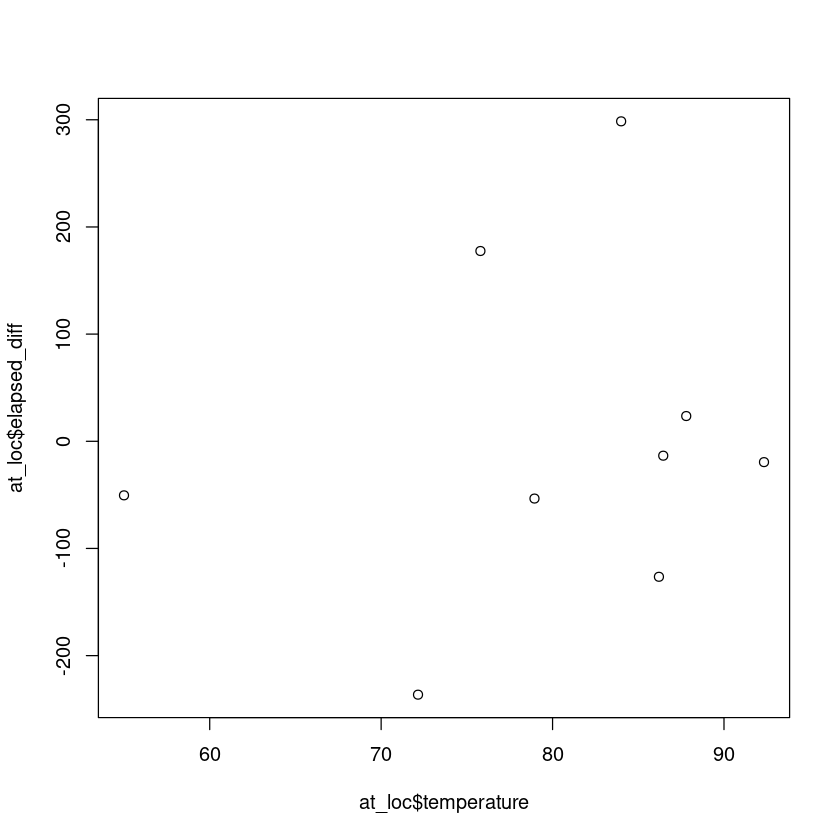

In [124]:
mean_elapsed <- unlist(map(elapsed_per_lat, function(el) {mean(el)}))
temperature_train_df <- data.frame(temperature=unlist(temperature_per_lat),
                                   elapsed=unlist(elapsed_per_lat),
                                   latitude=unlist(map(lat_vals, function(lat) {rep(lat, 9)})),
                                   day=factor(unlist(map(lat_vals, function(lat) {allowlist_days}))),
                                   mean_elapsed=unlist(map(mean_elapsed, function(el) {rep(el, 9)})),
                                   elapsed_diff=unlist(map(names(elapsed_per_lat), function(name) {
                                       elapsed_per_lat[[name]] - mean_elapsed[name]
                                   })))
head(mean_elapsed)
head(temperature_train_df)
ggplot(temperature_train_df, aes(x=mean_elapsed, y=elapsed_diff, color=day, alpha=temperature)) +
    geom_point() +
    labs(title="Original",
         y="y",
         x="Mean Elapsed")

model <- lm(elapsed_diff ~ latitude + mean_elapsed*log(temperature), temperature_train_df)
summary(model)
temperature_train_df$rectified_diff <- model$residuals

ggplot(temperature_train_df, aes(x=mean_elapsed,
                                 y=rectified_diff,
                                 color=day, alpha=temperature)) +
    geom_point() +
    labs(title="Residual",
         y="y",
         x="Mean Elapsed")

at_loc <- temperature_train_df[temperature_train_df$latitude == 5194000, ]
plot(at_loc$temperature, at_loc$elapsed_diff)

### Temperature's Effect on Speed

I will use a rough approximation of speed and then cut out 3 sigma outliers. I will then perform a regression.

In [ ]:
# TODO

# Model Building

In [70]:
to_utm <- function(long, lat) {
    spat_df <- SpatialPoints(coords=cbind(long, lat),
                                     proj4string=CRS("+proj=longlat +datum=WGS84 +units=m"))# This step converts the longitude/latitude -> UTM
    utm_df <- spTransform(spat_df, CRSobj = "+proj=utm +zone=12 +datum=WGS84 +units=m")
    utm_coords <- coordinates(utm_df)
    return(list(long=utm_coords[1, "long"], lat=utm_coords[1, "lat"]))
}

In [157]:
success_test <- function(test_long, test_lat, test_time, test_data) {
    dists <- unlist(map(1:dim(test_data)[1], function(idx) {
        row <- test_data[idx, ]
        real_dist(row$long_m, row$lat_m, test_long, test_lat)
    }))
    min_idx <- which.min(dists)
    time_diff <- abs(test_data$time[min_idx] - test_time)
    return(c(min(dists), time_diff))
}

density <- function(long, lat, train_data) {
    # get nearest point for each day
    days <- levels(factor(train_data$day))
    dists <- unlist(map(days, function(day) {
        day_data <- train_data[train_data$day == day, ]
        dists <- unlist(map(1:dim(day_data)[1], function(idx) {
            row <- day_data[idx, ]
            real_dist(row$long_m, row$lat_m, long, lat)
        }))
        return(min(dists))
    }))
    return(sum(log(dists)))
}

# raw predict returns UTM and not native lat/long and returns time seconds since the epoch
predict <- function(start_time, start_long, start_lat, train_data) {
    utm_coords <- to_utm(start_long, start_lat)
    days <- levels(factor(train_data$days))
    # now find latitude, longitude and time point with highest density
    plot(train_data)
    return(list(utm_latitude=0, utm_longitude=0, time=0))
}

test_model <- function(test_data, train_data) {
    prediction <- predict(test_data$time[1], test_data$longitude[1],
                          test_data$latitude[1], train_data)
    margin <- success_test(prediction$utm_latitude, prediction$utm_longitude,
                           prediction$time, train_data)
    cat("Off by:", margin[1], "\n")
    cat("With time error:", margin[2], "\n")
}

[1] 656   2

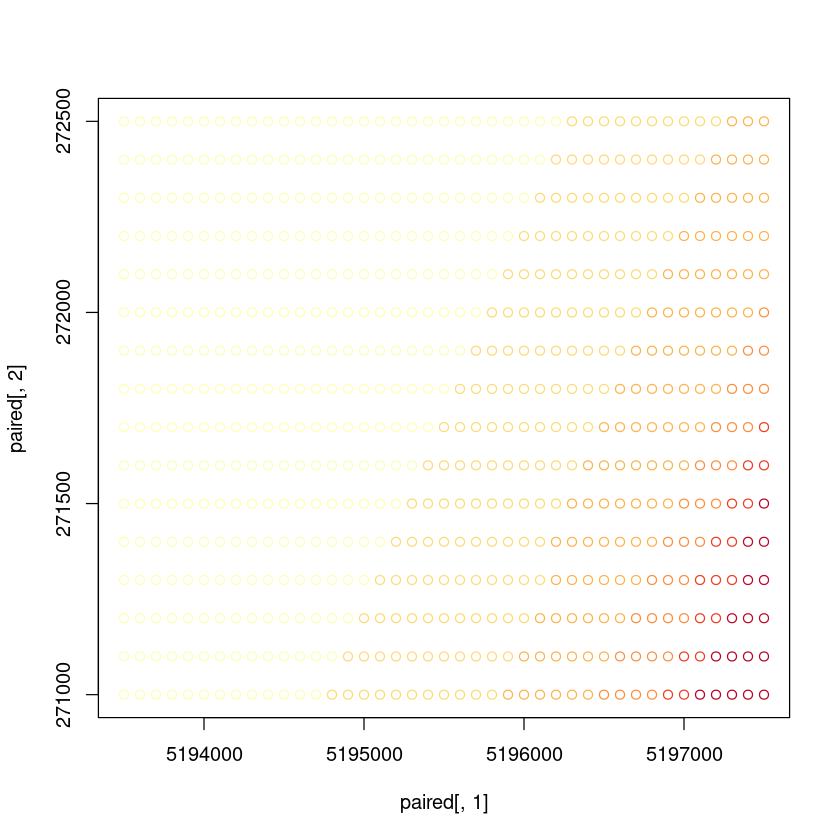

In [159]:
# first get density at a bunch of points
lats <- seq(271000, 272500, by=100)
longs <- seq(5193500, 5197500, by=100)
paired <- expand.grid(longs, lats)
dim(paired)
densities <- apply(paired, 1, function(row) {
    density(row[1], row[2], reduced_df[reduced_df$elapsed < 4000, ])
})
# now plot
library(RColorBrewer)
percs <- c(0, 0.5, 0.75, 0.9, 0.95, 0.975, 1)
breaks <- quantile(densities, percs)
col_cats <- cut(densities, breaks = breaks, include.lowest = TRUE)
cols <- brewer.pal(length(percs) - 1, "YlOrRd")
plot(paired[, 1], paired[, 2], col=cols[col_cats])

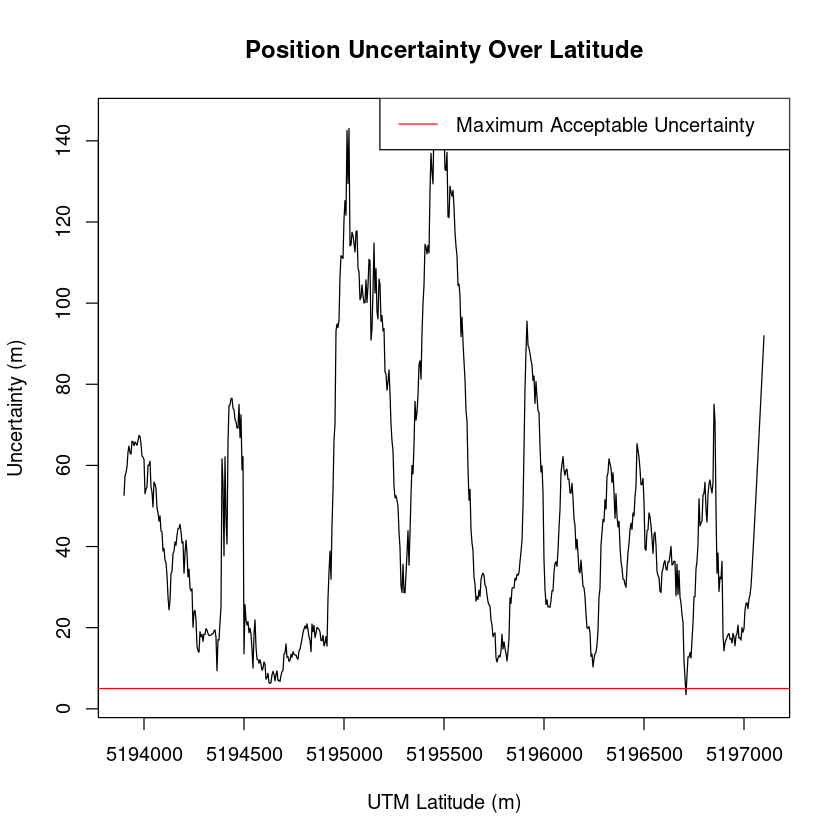

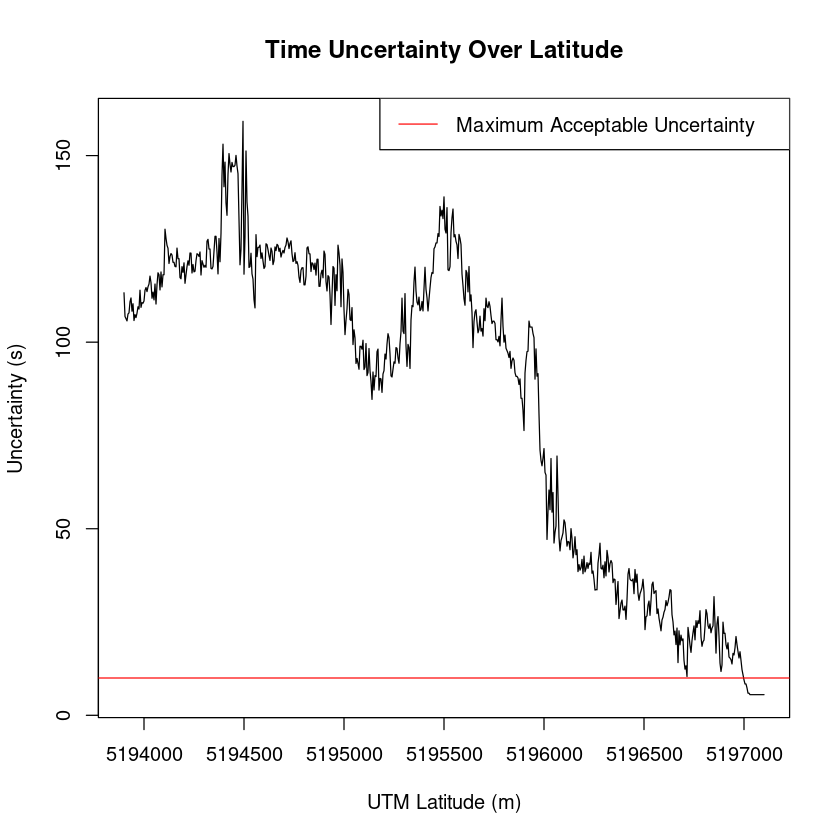

In [200]:
# METHOD: GO ALONG LATITUDE AND PLOT UNCERTAINTY
days <- c(1:8,11)
# now get train data slice
lats <- seq(5193900, 5197100, by=5)
train_data <- reduced_df[reduced_df$elapsed < 4000, ]
train_data <- train_data[reduced_df$day != 9, ]
train_data <- train_data[reduced_df$day != 10, ]
# now cache certain views
cache_longitudes <- list()
cache_elapsed <- list()
for (day in days) {
    cache_longitudes[[day]] <- train_data$long_m[train_data$day == day]
    cache_elapsed[[day]] <- train_data$elapsed[train_data$day == day]
}
# now get densities
all_uncertainties <- unlist(map(1:length(lats), function(idx) {
    lat <- lats[idx]
    dists <- abs(train_data$lat_m - lat)
    day_idxes <- rep(NA, 11)
    latitude_diff <- rep(NA, 11)
    longitudes <- rep(NA, 11)
    elapsed <- rep(NA, 11)
    for (day in days) {
        day_idxes[day] <- which.min(dists[train_data$day == day])
        latitude_diff[day] <- dists[train_data$day == day][day_idxes[day]]
        longitudes[day] <- cache_longitudes[[day]][day_idxes[day]]
        elapsed[day] <- cache_elapsed[[day]][day_idxes[day]]
    }
    # TODO: PREDICT BEST 2 LONGITUDES
    # Predict best longitudes and get their location uncertainty
    mean_long <- mean(longitudes, na.rm=TRUE)
    # go through every possible pairing and get the two with minimum uncertainty
    for (i in 1:(length(days)-1)) {
        for (j in (i+1):length(days)) {
            total_uncertainty <- sqrt((longitudes - mean_long)^2 + latitude_diff^2)
            uncertainty <- sum(total_uncertainty, na.rm=TRUE)/length(days)
        }
    }
    longitude_pred <- mean_long
    # Get position uncertainty
    total_uncertainty <- sqrt((longitudes - mean_long)^2 + latitude_diff^2)
    uncertainty <- sum(total_uncertainty, na.rm=TRUE)/length(days)
    # Now get time uncertainty
    time_uncertainty <- mean(abs(elapsed - mean(elapsed, na.rm=TRUE)), na.rm=TRUE)
    # Now return
    return(c(uncertainty, time_uncertainty, longitude_pred, longitude_pred))
}))
all_uncertainties <- matrix(all_uncertainties, ncol=4, byrow=TRUE)
lat_uncertainties <- all_uncertainties[, 1]
time_uncertainties <- all_uncertainties[, 2]
plot(lats, lat_uncertainties, type="l", xlab="UTM Latitude (m)",
     ylab="Uncertainty (m)", main="Position Uncertainty Over Latitude")
abline(h=5, col="red")
legend("topright", legend=c("Maximum Acceptable Uncertainty (5m)"), col=c("red"), lty=1)
plot(lats, time_uncertainties, type="l", xlab="UTM Latitude (m)",
     ylab="Uncertainty (s)", main="Time Uncertainty Over Latitude")
abline(h=10, col="red")
legend("topright", legend=c("Maximum Acceptable Uncertainty (10s)"), col=c("red"), lty=1)

In [78]:
for (day in 1:11) {
    cat("Test", day, "\n")
    test_model(reduced_df[reduced_df$day == day, ], reduced_df[reduced_df$day != day, ])
}

Test 1 
Off by: 5201024 
With time error: 1597975402 
Test 2 
Off by: 5201024 
With time error: 1597975402 
Test 3 
Off by: 5201029 
With time error: 1598566887 
Test 4 
Off by: 5201024 
With time error: 1597975402 
Test 5 
Off by: 5201024 
With time error: 1597975402 
Test 6 
Off by: 5201024 
With time error: 1597975402 
Test 7 
Off by: 5201024 
With time error: 1597975402 
Test 8 
Off by: 5201024 
With time error: 1597975402 
Test 9 
Off by: 5201024 
With time error: 1597975402 
Test 10 
Off by: 5201024 
With time error: 1597975402 
Test 11 
Off by: 5201024 
With time error: 1597975402 
